In [113]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

os.path.dirname(sys.executable)


'/home/amachuca/PycharmProjects/TFM_SAI/.venv/bin'

In [114]:
CUDA = True
DATA_PATH = './data'
EPOCH_NUM = 5
BATCH_SIZE = 32
IMAGE_CHANNEL = 1
Z_DIM = 100
X_DIM = 64
G_HIDDEN = 64
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 42
beta_1, beta_2 = 0.5, 0.999

# CUDA:                      If you want to use CUDA, change to CUDA = TRUE.
# DATA_PATH:                 Make sure that you should create a folder named “data” in the same folder containing your ipynb file before running the code.
# BATCH_SIZE:                The number of sub-samples given to the network. Bigger batch sizes learn faster but require more memory space.
# IMAGE_CHANNEL:             All images in MNIST are single channel, which means the gray scale image. Therefore, a value of IMAGE_CHANNEL is 1.
# Z_DIM:                     Size of z latent vector (i.e. size of generator input). It is used to generate random numbers for the generator.
# X_DIM:                     An original image size in MNIST is 28x28. I will change 28x28 to 64x64 with a resize module for the network.
# G_HIDDEN:                  Size of feature maps in the generator that are propagated through the generator.
# D_HIDDEN:                  Size of feature maps in the discriminator.
# EPOCH_NUM:                 The number of times the entire training dataset is trained in the network. Lager epoch number is better, but you should be careful of overfitting.
# REAL_LABEL and FAKE_LABEL: These labels will be used when calculating the losses of the discriminator and the generator during training.
# lr:                        The size of each step the network takes when it descends the error mountain. A learning rate that is too big speeds up the learning but is not guaranteed to find the minimum error.
# seed:                      Set random seed for reproducibility.

In [115]:
CUDA = torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__), "CUDA:", CUDA)
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.5.1+cu124 CUDA: True
CUDA version: 12.4



In [116]:
# Data preprocessing
dataset = dset.MNIST(
    root=DATA_PATH, 
    download=True,
    transform=transforms.Compose([
        transforms.Resize(X_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

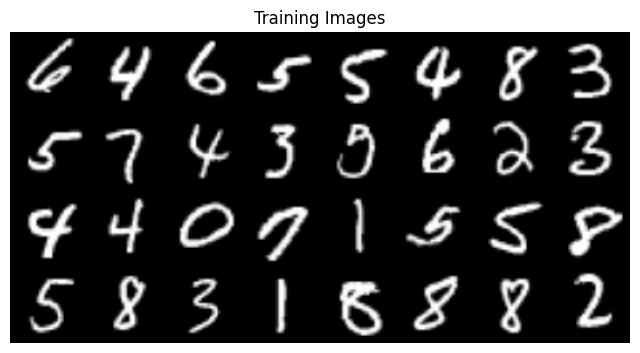

In [117]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [118]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            # input layer
            torch.nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(G_HIDDEN * 8),
            torch.nn.ReLU(True),
            # 1st hidden layer
            torch.nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(G_HIDDEN * 4),
            torch.nn.ReLU(True),
            # 2nd hidden layer
            torch.nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(G_HIDDEN * 2),
            torch.nn.ReLU(True),
            # 3rd hidden layer
            torch.nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(G_HIDDEN),
            torch.nn.ReLU(True),
            # output layer
            torch.nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [120]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # 1st layer
            torch.nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            torch.nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(D_HIDDEN * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            torch.nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(D_HIDDEN * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            torch.nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(D_HIDDEN * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # output layer
            torch.nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [121]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64

In [122]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
# viz_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta_1, beta_2))

In [123]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM,1,1, device=device)
        # noise = torch.randn(b_size, Z_DIM, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(tensor=fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1875]	Loss_D: 1.5064	Loss_G: 7.5092	D(x): 0.8152	D(G(z)): 0.6254 / 0.0008
[0/5][50/1875]	Loss_D: 0.1332	Loss_G: 10.8238	D(x): 0.9776	D(G(z)): 0.0902 / 0.0000
[0/5][100/1875]	Loss_D: 0.4402	Loss_G: 19.8961	D(x): 0.8324	D(G(z)): 0.0000 / 0.0000
[0/5][150/1875]	Loss_D: 0.0991	Loss_G: 4.3923	D(x): 0.9405	D(G(z)): 0.0267 / 0.0165
[0/5][200/1875]	Loss_D: 0.1410	Loss_G: 4.9585	D(x): 0.9763	D(G(z)): 0.0883 / 0.0086
[0/5][250/1875]	Loss_D: 0.1073	Loss_G: 3.4489	D(x): 0.9445	D(G(z)): 0.0453 / 0.0465
[0/5][300/1875]	Loss_D: 0.2654	Loss_G: 3.7677	D(x): 0.8907	D(G(z)): 0.1208 / 0.0398
[0/5][350/1875]	Loss_D: 0.2851	Loss_G: 2.6692	D(x): 0.8013	D(G(z)): 0.0269 / 0.1395


KeyboardInterrupt: 

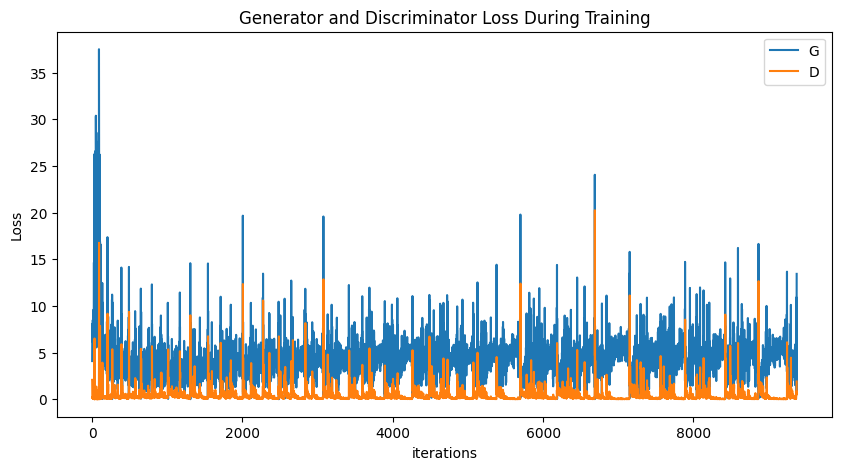

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

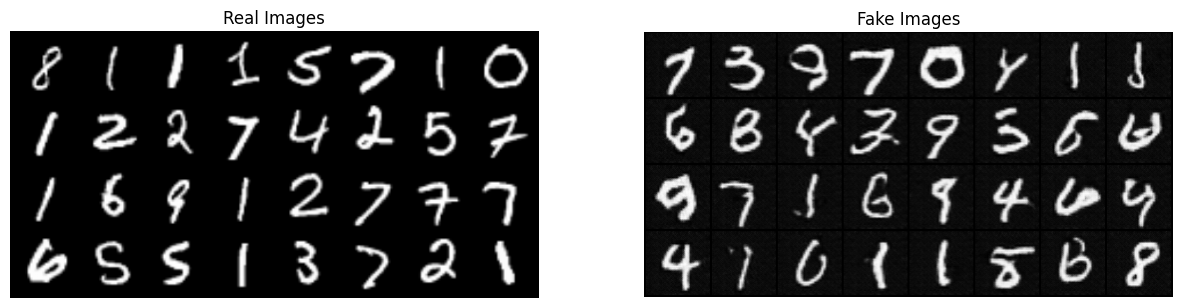

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
file_args = f"_{EPOCH_NUM}_{BATCH_SIZE}_{lr}_{beta_1}_{beta_2}_{Z_DIM}_{X_DIM}_{IMAGE_CHANNEL}"
torch.save(netG.state_dict(), f"./models/dcgan_v2/generator_{file_args}.pth")
torch.save(netD.state_dict(), f"./models/dcgan_v2/discriminator_{file_args}.pth")